In [1]:
!pip install -q --upgrade nest_asyncio
import nest_asyncio
nest_asyncio.apply()


In [2]:
from __future__ import absolute_import, division, print_function

import collections
import warnings
from six.moves import range
import numpy as np
import six
import tensorflow as tf
import tensorflow_federated as tff

warnings.simplefilter('ignore')

tf.compat.v1.enable_v2_behavior()

np.random.seed(0)

if six.PY3:
    tff.framework.set_default_executor(tff.framework.create_local_executor())

In [3]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

len(emnist_train.client_ids)

3383

In [4]:
print(emnist_train.output_types, emnist_train.output_shapes)

OrderedDict([('label', tf.int32), ('pixels', tf.float32)]) OrderedDict([('label', TensorShape([])), ('pixels', TensorShape([28, 28]))])


In [5]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0]
)
example_element = iter(example_dataset).next()

example_element['label'].numpy()

5

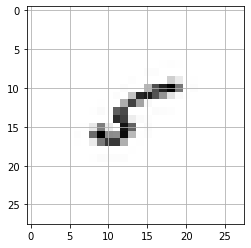

In [17]:
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid('off')
_ = plt.show()


In [7]:
NUM_CLIENTS = 10
NUM_EPOCHS = 10
BATCH_SIZE = 20
SHUFFLE_BUFFER = 500

def element_fn(element):
    return collections.OrderedDict([
        ('x', tf.reshape(element['pixels'], [-1])),
        ('y', tf.reshape(element['label'], [1]))
    ])

def preprocess(dataset):
    return dataset.repeat(NUM_EPOCHS).map(element_fn).shuffle(
        SHUFFLE_BUFFER).batch(BATCH_SIZE)

In [8]:
preprocessed_example_dataset = preprocess(example_dataset)
sample_batch = tf.nest.map_structure(
    lambda x: x.numpy(), iter(preprocessed_example_dataset).next()
)

sample_batch

OrderedDict([('x', array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y', array([[8],
                     [8],
                     [3],
                     [3],
                     [0],
                     [4],
                     [4],
                     [9],
                     [2],
                     [1],
                     [0],
                     [8],
                     [0],
                     [7],
                     [1],
                     [1],
                     [0],
                     [3],
                     [0],
                     [7]], dtype=int32))])

In [9]:
def make_federated_data(client_data, client_ids):
    return [preprocess(client_data.create_tf_dataset_for_client(x))
            for x in client_ids]
    

In [10]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]
federated_train_data = make_federated_data(emnist_train, sample_clients)
len(federated_train_data), federated_train_data[0]

(10,
 <BatchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>)

In [11]:
def create_compiled_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(
            10, 
            activation=tf.nn.softmax, 
            kernel_initializer='zeros',
            input_shape=(784,)
        )
    ])
    
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.02),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )
    
    return model

In [12]:
def model_fn():
    keras_model = create_compiled_keras_model()
    return tff.learning.from_compiled_keras_model(keras_model, sample_batch)

In [13]:
iterative_process = tff.learning.build_federated_averaging_process(model_fn)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
str(iterative_process.initialize.type_signature)

'( -> <model=<trainable=<dense/kernel=float32[784,10],dense/bias=float32[10]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)'

In [15]:
state = iterative_process.initialize()


In [16]:
state

AnonymousTuple([('model', AnonymousTuple([('trainable', AnonymousTuple([('dense/kernel', array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)), ('dense/bias', array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))])), ('non_trainable', AnonymousTuple([]))])), ('optimizer_state', AnonymousTuple([(None, 0)])), ('delta_aggregate_state', AnonymousTuple([])), ('model_broadcast_state', AnonymousTuple([]))])